<a href="https://colab.research.google.com/github/lseidy/IA_learning/blob/main/Regress%C3%A3o_com_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão linear, um exemplo

Neste notebook iremos aplicar regressão linear ao dataset de imóveis. Enquanto na tarefa de classificação tentamos identificar o tipo de imóvel, aqui tentaremos predizer o *preço* do imóvel a partir de suas características. Para simplificar, vamos focar em casas apenas.

# Carregando e filtrando os dados

In [ ]:
# Baixar os dados
!wget https://www.dropbox.com/s/skvenpz7p4szmoh/zap_imoveis.csv

# Vamos usar a biblioteca pandas para carregar e pré-processar os dados
import pandas as pd

dados_completos = pd.read_csv("zap_imoveis.csv", index_col=0)

--2020-10-27 20:38:37--  https://www.dropbox.com/s/skvenpz7p4szmoh/zap_imoveis.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/skvenpz7p4szmoh/zap_imoveis.csv [following]
--2020-10-27 20:38:37--  https://www.dropbox.com/s/raw/skvenpz7p4szmoh/zap_imoveis.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc09abb80d741bf43c35d19d2920.dl.dropboxusercontent.com/cd/0/inline/BCEfqeTxUyMVnVwv0tx2nsedMU2_kQ5rQEfV6uwsRzbrkQC0ab9QbqpdSjHtspmdr-RNw7RcjNg5J7Qey5ehNGLmQREeVyC7zdP1mGZu7vbAJ2toGHiA4pmMFgdA37_MI4A/file# [following]
--2020-10-27 20:38:38--  https://uc09abb80d741bf43c35d19d2920.dl.dropboxusercontent.com/cd/0/inline/BCEfqeTxUyMVnVwv0tx2nsedMU2_kQ5rQEfV6uwsRzbrkQC0ab9QbqpdSjHtspmdr-RNw7RcjNg5J7Qey5ehNGLmQREeVyC7zdP1mGZu7

In [ ]:
# Filtrar para ficarmos apenas com casas e apenas alguns atributos numéricos

dados = dados_completos[dados_completos.tipo_imovel=='Casa'][['num_suites', 'num_vagas', 'num_quartos',
       'area', 'condominio', 'preco']].reset_index(drop=True)

dados.head(3)

,num_suites,num_vagas,num_quartos,area,condominio,preco
0,2.0,2.0,3.0,150.0,0.0,570000
1,0.0,0.0,0.0,360.0,0.0,200000
2,0.0,1.0,2.0,45.0,18.0,170000


# Treinamento e avaliação

Vamos usar diretamente validação cruzada com K-Fold (K=10). Para simplificar, usaremos a função `cross_validate` do sklearn. Esta função executa a validação cruzada (K-Fold por padrão) e retorna o resultado de cada fold.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

X = dados.drop('preco', axis=1)
y = dados['preco']

modelo = LinearRegression()

# No método cross_valdiate podemos especificar as métricas que queremos que sejam calculadas
scores = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
resultados = cross_validate(modelo, X, y, cv=10, scoring=scores)

In [ ]:
# A saída do método cross_validate é um dicionário com o resultado de cada fold.
# Vamos transformar em um dataframe do Pandas para poder calcular as médias.

pd.DataFrame(resultados).mean()

fit_time                                 0.004209
score_time                               0.001549
test_neg_mean_absolute_error       -190326.045275
test_neg_root_mean_squared_error   -319936.384468
test_r2                                  0.114163
dtype: float64

Os valores `fit_time` e `score_time` são apenas os tempos para treinamento e avaliação e podemos ignorar. Observe que MAE e RMSE são mostrados com valores negativos. Isto é uma decisão de design da API do sklearn, de forma que para qualquer métrica a API sempre tenta maximizar a métrica, então métricas que são naturalmente positivas são tornadas negativas. Ignoremos o sinal.

Vemos que o modelo não é muito bom. O coeficiente de determinação (R^2) é bem baixo e um MAE de 190 mil reais não é particularmente incentivador. Podemos observar o gráfico de correlação entre valores preditos e reais para ver o que está acontencendo com um pouco mais de detalhes.

Vamos fazer isso em todo o conjunto de treino. Não é o ideal, mas como estamos usando um modelo linear, o risco de sobreajuste é muito baixo -- o modelo é simples demais para sobreajustar qualquer coisa.

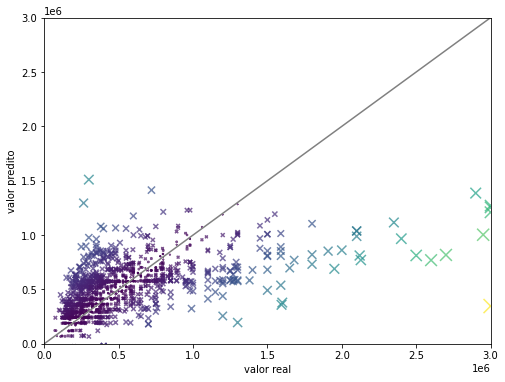

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

modelo_treinado = modelo.fit(X,y)
y_pred = modelo_treinado.predict(X)

# Vamos calcular os erros para usar no gráfico
# Quanto maior o erro, maior o tamanho do marcador e mais clara a sua cor
erros = np.abs(y_pred-y)
erros = erros / max(erros)

plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, s=200*erros, c=erros, alpha=0.7, marker='x')
plt.ylim(0,max(y_pred.max(), y.max()))
plt.xlim(0,max(y_pred.max(), y.max()))
plt.xlabel('valor real')
plt.ylabel('valor predito')

# Vamos mostrar a diagonal para deixar evidente os desvios
# Lembrando que queremos que todos pontos estejam nesta diagonal
plt.plot([0,max(y)], [0,max(y)], c='gray')

No gráfico acima, podemos ver que o modelo se sai melhor para valores baixos. A maior parte das casas tem valores baixos, então o modelo se ajustou principalmente sobre estes. Para valores mais altos, o modelo é bastante ruim, ele consistentemente *subestima* os preços de casas caras. Para valores baixos o contrário ocorre, mas os erros não são tão altos.

# Adicionando mais atributos

Claro, não deveríamos esperar muito dos poucos atributos que selecionamos. Deixamos de fora informações potencialmente importantes, como o bairro do imóvel e sua descrição. Vamos tentar usar estas informações.

Para a descrição, vamos apenas usar o comprimento em caracteres. Idealmente usaríamos técnicas mais sofisticadas, como *word embeddings*, mas isso terá que esperar.

Para o bairro, vamos transformar em um vetor *one-hot*, binarizando o atributo em múltiplas colunas, como fizemos para o classificador.

In [ ]:
from sklearn.preprocessing import LabelBinarizer
def binarizar(df, coluna):
  cod = LabelBinarizer()
  cod.fit(df[coluna])
  atributo_transformado = cod.transform(df[coluna])
  onehot = pd.DataFrame(atributo_transformado)
  onehot.columns = cod.classes_

  return pd.concat([df, onehot], axis=1).drop([coluna], axis=1)

dados = dados_completos[dados_completos.tipo_imovel=='Casa'][['num_suites', 'num_vagas', 'num_quartos',
       'area', 'preco', 'descricao', 'bairro', 'condominio']].reset_index(drop=True).dropna(subset=['bairro'])

dados['descricao'] = dados['descricao'].str.len()
dados = binarizar(dados, 'bairro')
dados.head(3)

,num_suites,num_vagas,num_quartos,area,preco,descricao,condominio,Arco Iris,Areal,Baronesa,Barro Duro,Bom Jesus,Centro,Cohab II,Cohab Lindóia,Cohab Tablada,Colina Verde,Colina da Sol,Cruzeiro,Fragata,Fátima,Indeterminado,Jardim América,Jardim das Tradições,Laranjal,Laranjal Val Verde,Las Acácias,Lindóia,Navegantes,Obelisco,Pontal da Barra,Porto,Recanto de Portugal,Santa Terezinha,Simões Lopes,São Gonçalo,Sítio Floresta,Treptow,Três Vendas,Umuharama,Vila Assunção,Vila Jardim Europa,Vila Mariana,Vila Princesa,Zona Norte,Zona Rural
0,2.0,2.0,3.0,150.0,570000.0,143.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,360.0,200000.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,2.0,45.0,170000.0,143.0,18.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = dados.drop('preco', axis=1).fillna(0)
y = dados['preco']

modelo = LinearRegression()
scores = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
resultados = cross_validate(modelo, X, y, cv=10, scoring=scores)
pd.DataFrame(resultados).mean()

fit_time                                 0.007286
score_time                               0.002531
test_neg_mean_absolute_error       -180691.045930
test_neg_root_mean_squared_error   -300205.520261
test_r2                                  0.238643
dtype: float64

Um pouco melhor! Reduzimos o MAE para 180 mil reais e o R^2 subiu para 0.23. Vamos ver o gráfico de correlação.

Text(0, 0.5, 'valor predito')

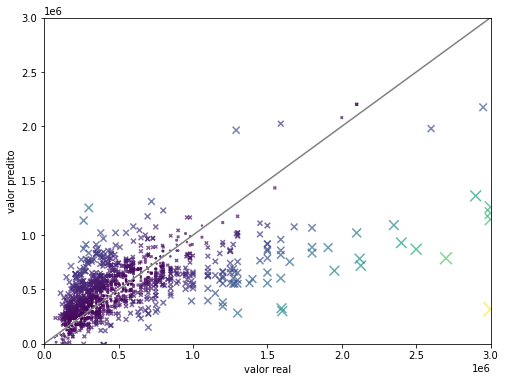

In [ ]:
modelo_treinado = modelo.fit(X,y)
y_pred = modelo_treinado.predict(X)


erros = np.abs(y_pred-y)
erros = erros / max(erros)
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, s=200*erros, c=erros, alpha=0.7, marker='x')
plt.ylim(0,max(y_pred.max(), y.max()))
plt.xlim(0,max(y_pred.max(), y.max()))

plt.plot([0,max(y)], [0,max(y)], c='gray')
plt.xlabel('valor real')
plt.ylabel('valor predito')

Qualitativamente continuamos com o mesmo problema, o modelo subestima casas caras e superestima casas mais baratas. Podemos tentar resolver isso com mais ou melhores atributos ou com modelos mais complexos.

# Próximos passos

Façam uma cópia deste notebook e vejam se há algum tipo de imóvel para o qual se consegue algum tipo de ajuste razoável. E o que acontece se simplesmente introduzirmos tipo_imovel como um atributo?